In [1]:
import os

import pandas as pd
import geopandas as gpd
import json

import altair as alt
import gpdvega
#alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Inladen Data

In [2]:
data = '20181204_Water- en stoffenbalans ZZL.xlsx'
sheet = 'Dagdebieten2015-2017'#
# lees de data het is een multi - index kolomnaam: (naam, vanuit, naar)
data = pd.read_excel(data, sheet_name = sheet, header = [3, 4, 5])
data = data.iloc[: 1097]# selecteer alleen de tijdseries

kolomnamen = []
vannamen = []
naarnamen = []
for col in data.columns:
    kolomnamen.append(col[0])
    vannamen.append(col[1])
    naarnamen.append(col[2])

data.columns = kolomnamen
vannaar = pd.DataFrame({
    'van': vannamen,
    'naar': naarnamen
}, index = kolomnamen)

data.to_csv('basisdata.csv', sep = ';')
vannaar.to_csv('vannaar.csv', sep = ';')

# resample to week
data = data.astype(float)
data.index = pd.to_datetime(data.index)
data = data.resample('W-MON').sum()
data.head()

,AWZI Zeewolde,AWZI Almere,AWZI Lelystad,AWZI Dronten,AWZI Tollebeek,Lozing McCain,Zuidersluis (schuttingen),Zuidersluis (doorvoer),Gemaal De Blocq van Kuffeler Hoog,Almeresluis,...,Marknessersluis (rinket),Marknessersluis (schuttingen),Stuw Marknesse,Gemaal Expansie,Aflaatschuif Expansie,Stuw Kalenbergertocht 1,Stuw kassengebied Luttelgeest,Stuw Blankenhammertocht,AMT stuw,Stuw Kuindertocht
2015-01-05,22070.0,155590.0,62460.0,34845.0,72331.0,10093.913,22780.602806,0.0,0.000,32.258065,...,376141.185800,1499.24268,0.0,0.0,0.0,85746.532,85269.452,35000.0,47853.122,48114.262
2015-01-12,34240.0,237330.0,92720.0,74616.0,184883.0,14525.917,102512.712629,0.0,13232.468,45.161290,...,698935.684228,1499.24268,0.0,0.0,0.0,216121.126,124925.174,49000.0,140056.417,73462.016
2015-01-19,37012.0,260720.0,108000.0,92253.0,276897.0,14986.092,136683.616838,0.0,2269087.680,45.161290,...,645525.281309,499.74756,0.0,21600.0,0.0,272007.000,126781.268,49000.0,84523.752,119454.334
2015-01-26,31990.0,225950.0,95220.0,54367.0,128585.0,15446.268,167057.753914,0.0,626926.504,45.161290,...,692590.937605,999.49512,0.0,0.0,0.0,248.837,117692.690,49000.0,81388.858,70754.991
2015-02-02,35800.0,247110.0,102610.0,71658.0,189207.0,15906.445,87325.644091,0.0,2228938.704,60.829493,...,778380.828301,0.00000,0.0,0.0,0.0,24426.831,127087.219,49000.0,111583.299,102904.683


Unstack de data zodat er gefilterd kan worden op de data

In [3]:
data2 = data.unstack().reset_index(name='value')
data2.columns = ['Locatie', 'Datum', 'Debiet m3/s']

station = gpd.read_file('stations_4326.shp')
station.loc[:,'lon'] = station.geometry.x
station.loc[:,'lat'] = station.geometry.y
station = pd.DataFrame(station.drop(columns='geometry'))
data2 = data2.merge(station, left_on='Locatie', right_on='OMSCHRIJVI')

data2.tail()

,Locatie,Datum,Debiet m3/s,X,Y,OMSCHRIJVI,lon,lat
6903,Stuw Kuindertocht,2017-12-04,75410.558,185532,530568,Stuw Kuindertocht,5.839518,52.761572
6904,Stuw Kuindertocht,2017-12-11,76230.000,185532,530568,Stuw Kuindertocht,5.839518,52.761572
6905,Stuw Kuindertocht,2017-12-18,76230.000,185532,530568,Stuw Kuindertocht,5.839518,52.761572
6906,Stuw Kuindertocht,2017-12-25,76230.000,185532,530568,Stuw Kuindertocht,5.839518,52.761572
6907,Stuw Kuindertocht,2018-01-01,82876.526,185532,530568,Stuw Kuindertocht,5.839518,52.761572


In [4]:
locaties = data2.Locatie.unique().tolist()

In [5]:
# parse background data map
shape_flevo = gpd.read_file(r"D:\jupyter notebooks\3834.10 ZZL Datavalidatie\shapefile\Flevoland_4326_correctv2.shp")

# dump as json and load as a GeoJSON object.
json_gdf = shape_flevo.to_json()
json_features = json.loads(json_gdf)
data_geo = alt.Data(values=json_features['features'])

In [8]:
select_box = alt.binding_select(options=locaties)
selection = alt.selection_single(name='Locatie', fields=['Locatie'], bind=select_box, nearest=True)
nearest = alt.selection(type='single', nearest=True, on='mouseover', fields=['lat', 'lon'], empty='none')

chart = alt.Chart(data2).mark_trail().encode(
    x='Datum',
    y='Debiet m3/s',
    size=alt.Size('Debiet m3/s', legend=None),
    color = alt.value('orange'),
    tooltip = ['Locatie','Debiet m3/s']
).add_selection(
    selection
).transform_filter(
    selection
)#.interactive(bind_y=False)


map_base = alt.Chart(data_geo).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(  
    width=300,
    height=300
)

nearest_station = alt.Chart(data2[['Locatie', 'lat', 'lon']].drop_duplicates()).mark_point().encode(
    latitude='lat',
    longitude='lon',
    size=alt.condition(nearest, alt.value(85), alt.value(50)),
).add_selection(
    nearest
)

map_stations = alt.Chart(data2[['Locatie', 'lat', 'lon']].drop_duplicates()).mark_point().encode(
    latitude='lat',
    longitude='lon',
    tooltip='Locatie',
    color=alt.condition(selection, alt.value('orange'), alt.value('lightblue'), legend=None),
)

title = alt.Chart(data2[['Locatie', 'lat', 'lon']].drop_duplicates()).mark_text(dy=-160, size=12).encode(
    text='Locatie:N'
).transform_filter(
    selection
)

figure = (map_base + nearest_station + map_stations )| (chart + title)

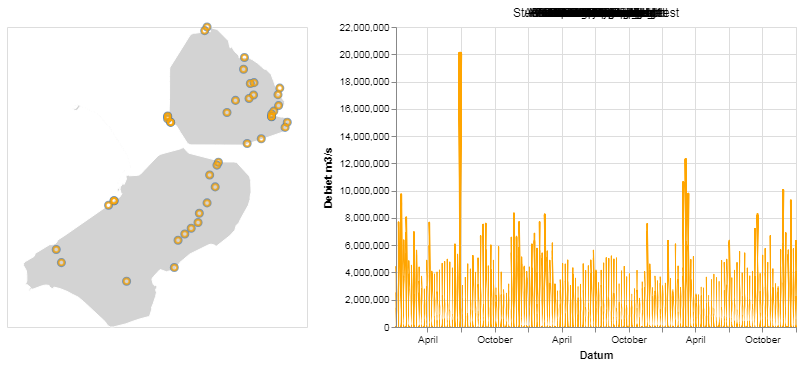

In [9]:
figure

In [10]:
figure.save('comb_map_chart.html')